In [98]:
%pylab inline

import seaborn
import matplotlib.pyplot as plt
import natto
import IPython

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

#from descr import boxy_notebook
#from descr.util import Table
#import pprint 
# pr = boxy_notebook(always_setup = True)

d = sc.textFile("/root/ukpolice/2014-*/*-street.csv")

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [99]:
def pr(x):
    return IPython.display.HTML(natto.natto(x,with_css=True))

In [100]:
d.count()

5656486

In [101]:
header = d.take(1)[0]
datarows = d.filter( lambda x: x != header )
print header

Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context


In [102]:
print datarows.take(1) 
pr( datarows.map( lambda x: (len(x.split(",")),1) ).countByKey() )

[u',2014-05,Essex Police,Essex Police,0.439197,51.642719,On or near Potash Road,E01021237,Basildon 001A,Anti-social behaviour,,']


In [103]:
okdata = datarows.map( lambda x: x.split(",")).filter( lambda x: len(x) == 12 )
hdrdata = header.split(",")
print hdrdata
print okdata.count(), len(hdrdata)

[u'Crime ID', u'Month', u'Reported by', u'Falls within', u'Longitude', u'Latitude', u'Location', u'LSOA code', u'LSOA name', u'Crime type', u'Last outcome category', u'Context']
5655827 12


In [104]:
semidata = okdata.map( lambda x: dict( zip( hdrdata, x )))
# extract a single row (as a dictionary) and display it as a table
pr(semidata.take(1)[0])

In [105]:
rows = semidata.map(lambda x: pyspark.sql.Row(**x))
df = sqlContext.createDataFrame(rows)
df.registerAsTable("crime")
# sqlContext.sql("select count(*) from crime").collect()

In [106]:
# aggregate the counts for each combination of 'Çrime type' and 'Last outcome category'
outcomes = semidata.map( lambda x: ((x['Crime type'], x['Last outcome category']),1)).countByKey()

In [107]:
counts = sqlContext.sql( """select `Crime type`, `Last outcome category`, count(*) as count from crime group by `Crime type`, `Last outcome category` """).collect()

Other crime


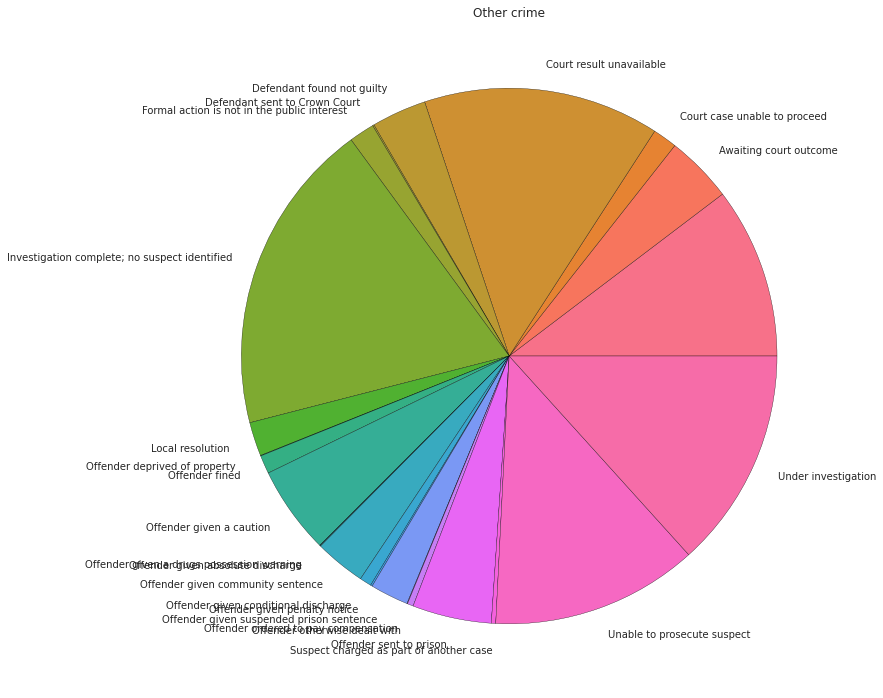

In [108]:
crimetypes = sqlContext.sql("select distinct `Crime type` from crime").rdd.map(lambda x:x[0]).collect()
outcometypes = sqlContext.sql("select distinct `Last outcome category` from crime").rdd.map(lambda x:x[0]).collect()

ct = crimetypes[9]
print ct

selectedoutcomes = {outcome:cnt for ctype,outcome,cnt in counts if ctype==ct}
labels = sorted(selectedoutcomes.keys())
sizes = [selectedoutcomes[key] for key in keys]

pcolors = seaborn.color_palette( "husl",n_colors = len(labels) )

plt.figure(figsize=(12,12))
plt.pie(sizes, labels=labels, colors=pcolors)
plt.title(ct)
None

In [109]:
cols = crimetypes
rows = sorted(outcometypes) # all outcome types

import numpy
stats = numpy.zeros( (len(rows),len(cols)) ,dtype=float )
for ctype,outcome,cnt in counts:
    stats[rows.index(outcome),cols.index(ctype)] = cnt

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)
    
stats = normalized(stats,axis=0)
    
#fig = plt.figure(figsize=(20,1))
#ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])
#ax.xaxis.set_visible(False)
#ax.yaxis.set_visible(False)
#q = ax.table(cellText = stats, rowLabels = rows, colLabels = cols, cellColours=matplotlib.pylab.cm.Blues(stats))
#plt.savefig("out.pdf")

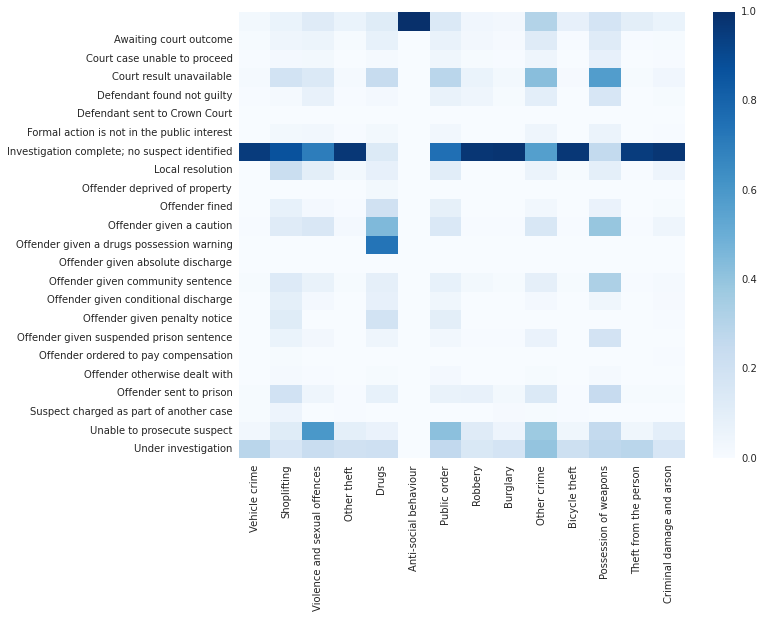

In [110]:
plot=seaborn.heatmap(stats,xticklabels=cols,yticklabels=rows,cmap=matplotlib.pylab.cm.Blues)

In [111]:
# which regions are similar in the type of crimes they handle?
# deeper analytics

def mkFeature(d):
    #f = numpy.zeros((len(crimetypes),len(rows)),dtype = float)
    #f[crimetypes.index(d['Crime type']), rows.index(d['Last outcome category'])] = 1.0
    f = numpy.zeros((len(crimetypes)),dtype = float)
    f[crimetypes.index(d['Crime type'])] = 1.0
    return f

def normalizeFeature( f ):
    f = f.flatten()
    return f / numpy.sum(f)

featureVectors = semidata.map( lambda x: (x['Reported by'],mkFeature(x)) ).reduceByKey( lambda x,y : x + y )
fmap = featureVectors.mapValues( normalizeFeature ).collectAsMap()



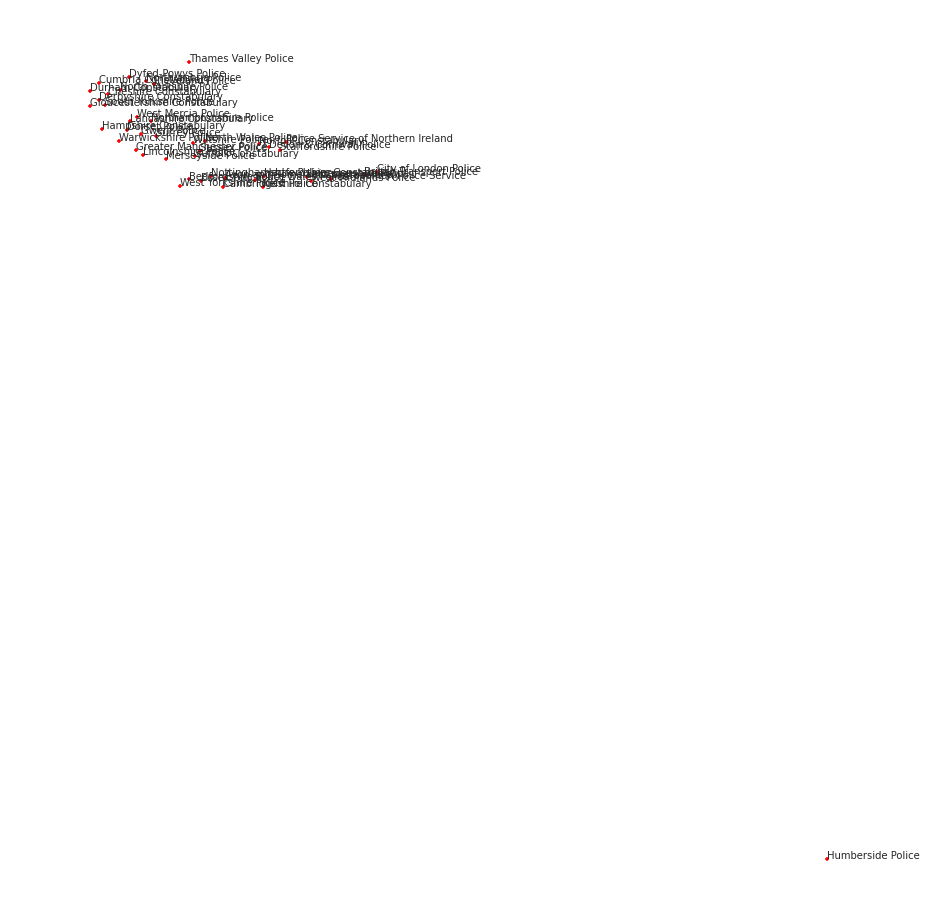

In [112]:
# embed the feature vectors
import tsne

embedding = tsne.bh_sne(numpy.array(fmap.values()),perplexity=4)
embedding

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, axisbg='white')

matplotlib.pyplot.plot( embedding[:,0], embedding[:,1], 'r.')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
for region, pnt in zip(fmap.keys(),embedding):
    ax.annotate(region, xy=pnt )

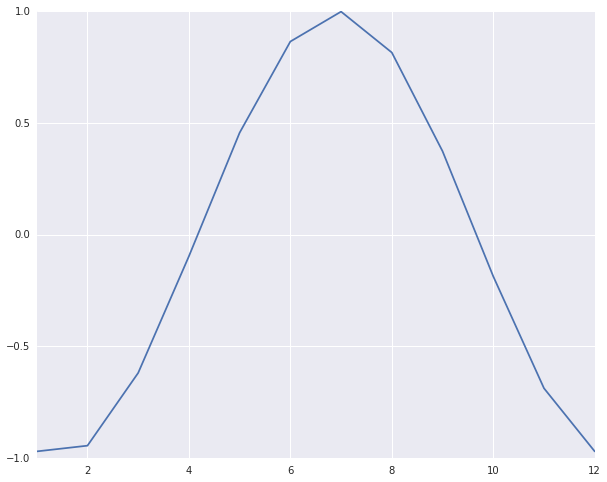

In [113]:
# look at seasonal effects

monthly_counts = semidata.map( lambda x: ((x['Crime type'], int(x['Month'][-2:],10)),1)).countByKey()

# build a seasonal temperature curve
season = -cos(2.0*3.1415*numpy.linspace(0,1,12) -0.24)
pylab.plot(range(1,13),season)
pylab.xlim([1,12])
pylab.show()

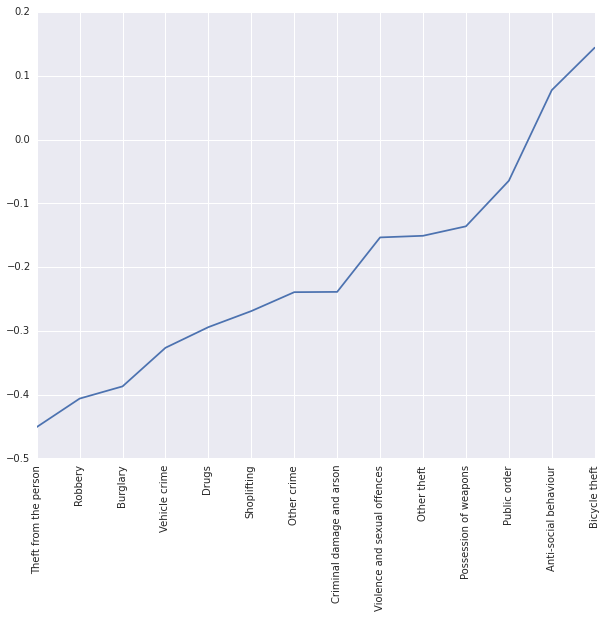

In [114]:
rows = sorted(list(set([x[0] for x in monthly_counts.keys()])))
cols = sorted(list(set([x[1] for x in monthly_counts.keys()])))

#print cols,rows
countarray = numpy.zeros(  (len(rows),len(cols)), dtype=float )
for k,v in monthly_counts.items():
    countarray[ rows.index(k[0]), cols.index(k[1]) ] = v
    
countarray = normalized(countarray,axis=1)


ranked = sorted( zip(countarray.dot(season),countarray,rows) )

lplot = pylab.plot([x[0] for x in ranked])
pylab.xticks(range(len(ranked)), [x[2] for x in ranked], rotation='vertical')
pylab.xlim([0,len(ranked)-1])
pylab.show()


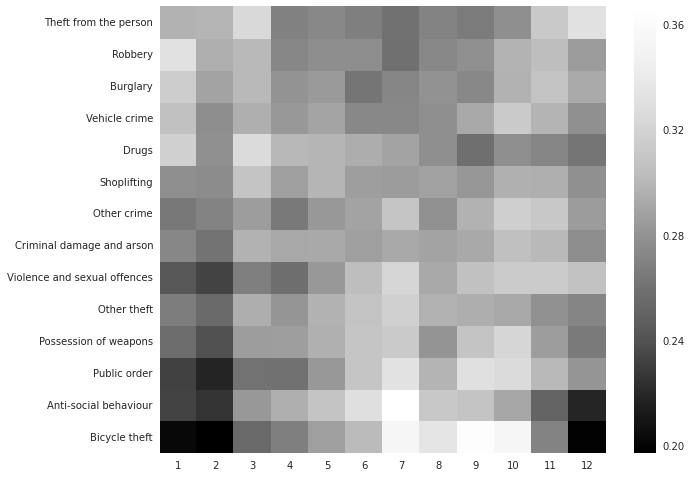

In [115]:
sorted_countarray = [x[1] for x in ranked]
sorted_rows = [x[2] for x in ranked]

hplot = seaborn.heatmap(sorted_countarray,xticklabels=cols, yticklabels=sorted_rows, cmap=matplotlib.pylab.cm.Greys_r)